# Working with the Reddit comments dataset

  - The Reddit comments dataset was shared with the world as a folder hierarchy of compressed json files.
  - This collection of files was downloaded via torrent and uploaded to the Cypress Cluster's HDFS file system.

### Original file format hierarchy

  - This dataset now resides under the /datasets/reddit_data directory on HDFS.
  - Each file contains the comments of a particular month.
  - Each file contains json objects (one per line of the file), corresponding to each reddit comment.
  - The original input files are compressed with bz2.
    - bz2 has good compression but parallelism for compression/decompression is limited to the number of .bz2 files

In [1]:
!hdfs dfs -ls -R hdfs:///datasets/reddit_data

drwxr-xr-x   - denton hdfs          0 2015-07-29 14:30 hdfs:///datasets/reddit_data/2007
-rw-r--r--   2 denton hdfs   13272008 2015-07-29 14:30 hdfs:///datasets/reddit_data/2007/RC_2007-10.bz2
-rw-r--r--   2 denton hdfs   28680340 2015-07-29 14:30 hdfs:///datasets/reddit_data/2007/RC_2007-11.bz2
-rw-r--r--   2 denton hdfs   31154059 2015-07-29 14:30 hdfs:///datasets/reddit_data/2007/RC_2007-12.bz2
drwxr-xr-x   - denton hdfs          0 2015-07-29 14:31 hdfs:///datasets/reddit_data/2008
-rw-r--r--   2 denton hdfs   38009966 2015-07-29 14:30 hdfs:///datasets/reddit_data/2008/RC_2008-01.bz2
-rw-r--r--   2 denton hdfs   37121419 2015-07-29 14:31 hdfs:///datasets/reddit_data/2008/RC_2008-02.bz2
-rw-r--r--   2 denton hdfs   38882745 2015-07-29 14:31 hdfs:///datasets/reddit_data/2008/RC_2008-03.bz2
-rw-r--r--   2 denton hdfs   39830391 2015-07-29 14:31 hdfs:///datasets/reddit_data/2008/RC_2008-04.bz2
-rw-r--r--   2 denton hdfs   45261937 2015-07-29 14:31 hdfs:///datasets/reddit_data/2008/RC_20

### New file format hierarchy - a Parquet directory filled with snappy compressed files and a schema
#### I will share how I converted the data another time.

  - The file format we will be using will take up more space on HDFS but decompress **much** faster, depending on the resources you've allocated. (TODO: verify this!)
  - The original file hierarchy was loaded into a *Spark dataframe* with one call to Spark's load.json function
    - the data was automatically decompressed and the *schema* for the json objects was inferred (TODO: how?)
    - TODO: manually optimize schema for better storage efficiency?
      - How well did Spark do with this task automatically?
    - TODO: drop unnecessary columns
  - The dataframe was repartitioned for max parallelism (for my resource allocation at the time)
    - it was then written into a Parquet file leveraging [Snappy](http://google.github.io/snappy/) compression
  - The new file is stored on HDFS at: hdfs:///datasets/reddit_snappy.parquet
  - The [Parquet](https://parquet.apache.org/) file format:
    - "Apache Parquet is a columnar storage format available to any project in the Hadoop ecosystem, regardless of the choice of data processing framework, data model or programming language."

In [64]:
!hdfs dfs -ls -R hdfs:///datasets/reddit_snappy.parquet

-rw-r--r--   2 denton hdfs          0 2016-09-17 20:53 hdfs:///datasets/reddit_snappy.parquet/_SUCCESS
-rw-r--r--   2 denton hdfs       3086 2016-09-17 20:53 hdfs:///datasets/reddit_snappy.parquet/_common_metadata
-rw-r--r--   2 denton hdfs   17078152 2016-09-17 20:53 hdfs:///datasets/reddit_snappy.parquet/_metadata
-rw-r--r--   2 denton hdfs  172336072 2016-09-17 20:50 hdfs:///datasets/reddit_snappy.parquet/part-r-00000-bd7e0053-1e12-499f-af1f-01bbe164f78b.snappy.parquet
-rw-r--r--   2 denton hdfs  172263615 2016-09-17 20:46 hdfs:///datasets/reddit_snappy.parquet/part-r-00001-bd7e0053-1e12-499f-af1f-01bbe164f78b.snappy.parquet
-rw-r--r--   2 denton hdfs  172401171 2016-09-17 20:50 hdfs:///datasets/reddit_snappy.parquet/part-r-00002-bd7e0053-1e12-499f-af1f-01bbe164f78b.snappy.parquet
-rw-r--r--   2 denton hdfs  171829851 2016-09-17 20:50 hdfs:///datasets/reddit_snappy.parquet/part-r-00003-bd7e0053-1e12-499f-af1f-01bbe164f78b.snappy.parquet
-rw-r--r--   2 denton hdfs  171990900 2016-09-

In [63]:
!hdfs dfs -du -h -s /datasets/*

149.6 G  /datasets/reddit_data
269.4 G  /datasets/reddit_snappy.parquet


Let's determine who is running this notebook. You should see your username used in the commands below (not your lecturer's).

In [65]:
import os
user = os.environ['USER']
print('I am user ' + user)

I am user denton


In [66]:
my_hdfs_dir = 'hdfs:///user/' + user + '/'
print("My HDFS directory is: " + my_hdfs_dir)

My HDFS directory is: hdfs:///user/denton/


### Load the data from HDFS into memory and cache it there for future operations.

In [76]:
%%time
reddit = sqlContext.read.load('hdfs:///datasets/reddit_snappy.parquet').cache()

CPU times: user 1.06 ms, sys: 10.1 ms, total: 11.1 ms
Wall time: 287 ms


### That was too fast! Why? Spark hasn't actually loaded the data yet and it won't until it has to.

We do have the persisted schema from the Parquet format loaded.

In [79]:
%%time
reddit.printSchema()

root
 |-- approved_by: string (nullable = true)
 |-- archived: boolean (nullable = true)
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- banned_by: string (nullable = true)
 |-- body: string (nullable = true)
 |-- body_html: string (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created: long (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- downs: long (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- likes: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- mod_reports: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- name: string (nullable = true)
 |-- num_reports: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- removal_reason: string (nullable = true)
 |-- r

### This will cause the dataset to be cached in memory since it must all be processed in order to provide you with an answer.

In [80]:
%%time
reddit.count()

CPU times: user 44.1 ms, sys: 19.3 ms, total: 63.4 ms
Wall time: 4min 30s


1659361605

### It makes sense to cache DataFrames and RDDs we think we will use over and over again because the data won't have to be loaded from disk repeatedly.

In [81]:
%%time
reddit.count()

CPU times: user 1.27 ms, sys: 2.09 ms, total: 3.36 ms
Wall time: 2.27 s


1659361605

### Notice how much faster it ran the second time since the data was already available for analysis in memory!

In [82]:
%%time
print("reddit partitions = ", reddit.rdd.getNumPartitions())

('reddit partitions = ', 3360)
CPU times: user 0 ns, sys: 3.83 ms, total: 3.83 ms
Wall time: 10.8 ms


### Here is how you show 10 records of the data set:

In [85]:
%%time
reddit.show(10)

+-----------+--------+---------------+----------------------+-----------------+---------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+-----+--------+-----------+----------+-----------+----------+--------------+-------+--------------+------------+-----+-----+------------+-------------------+------------+---+------------+
|approved_by|archived|         author|author_flair_css_class|author_flair_text|banned_by|                body|body_html|controversiality|created|created_utc|distinguished|downs|edited|gilded|     id|likes| link_id|mod_reports|      name|num_reports| parent_id|removal_reason|replies|report_reasons|retrieved_on|saved|score|score_hidden|          subreddit|subreddit_id|ups|user_reports|
+-----------+--------+---------------+----------------------+-----------------+---------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+-----+--------+-----------+

#### Lets group records by subreddit and count them. This also sorts the resulting data frame.

In [86]:
%%time
top_subreddits = reddit.groupBy("subreddit").count().sort("count", ascending=False).cache()

CPU times: user 10.1 ms, sys: 3.02 ms, total: 13.1 ms
Wall time: 10 s


## One way to plot Spark DFs is to convert your Spark DF into a Pandas DF and then call the plot method of the Pandas DF. 
#### Don't convert too large a DataFrame to Pandas or your PySpark driver might die due to Out of Memory issues.

For displaying the plot in the notebook:

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt

Ignore the warning above.

In [88]:
import pandas as pd

In [89]:
%%time
pandas_df = top_subreddits.toPandas()

CPU times: user 1.61 s, sys: 120 ms, total: 1.73 s
Wall time: 3.99 s


In [90]:
type(pandas_df)

pandas.core.frame.DataFrame

In [91]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239772 entries, 0 to 239771
Data columns (total 2 columns):
subreddit    239772 non-null object
count        239772 non-null int64
dtypes: int64(1), object(1)
memory usage: 5.5+ MB


#### Also do not plot too many records. 100s of data points are OK but go beyond that at your own risk.

#### Use the Pandas DataFrame head function to reduce the number of records in your data frame.

In [92]:
pandas_df = pandas_df.head(50)

In [93]:
pandas_df

,subreddit,count
0,AskReddit,184540520
1,funny,49967219
2,pics,47208205
3,gaming,32202209
4,WTF,29779435
5,leagueoflegends,29706965
6,AdviceAnimals,27339965
7,politics,22904996
8,videos,21235667
9,worldnews,19687581


In [94]:
print(pandas_df.to_csv())

,subreddit,count
0,AskReddit,184540520
1,funny,49967219
2,pics,47208205
3,gaming,32202209
4,WTF,29779435
5,leagueoflegends,29706965
6,AdviceAnimals,27339965
7,politics,22904996
8,videos,21235667
9,worldnews,19687581
10,todayilearned,18508173
11,IAmA,18298109
12,nfl,17116723
13,atheism,16138248
14,trees,14312315
15,nba,12929889
16,reddit.com,12560130
17,soccer,11566836
18,movies,10617752
19,DotA2,10179173
20,news,9881729
21,gonewild,9383775
22,hockey,9336295
23,technology,8743613
24,fffffffuuuuuuuuuuuu,8426373
25,CFB,7569656
26,aww,7259234
27,SquaredCircle,7125388
28,pcmasterrace,6644799
29,starcraft,6639666
30,Games,6639213
31,teenagers,6556931
32,Random_Acts_Of_Amazon,6226399
33,Music,5930946
34,friendsafari,5805661
35,Minecraft,5757242
36,gifs,5700185
37,science,5637737
38,Fitness,5564464
39,pokemon,5290247
40,buildapc,5103386
41,explainlikeimfive,5076429
42,Android,5037563
43,relationships,5024764
44,TwoXChromosomes,4919229
45,DestinyTheGame,4635881
46,sex,4454166
47,guns,4425019
48

In [96]:
pandas_df.to_csv('top-fifty-subreddits-2008-to-2015.csv')

In [99]:
ls -lh 'top-fifty-subreddits-2008-to-2015.csv'

-rw-r--r-- 1 denton cuuser 1.1K Sep 18 11:52 top-fifty-subreddits-2008-to-2015.csv


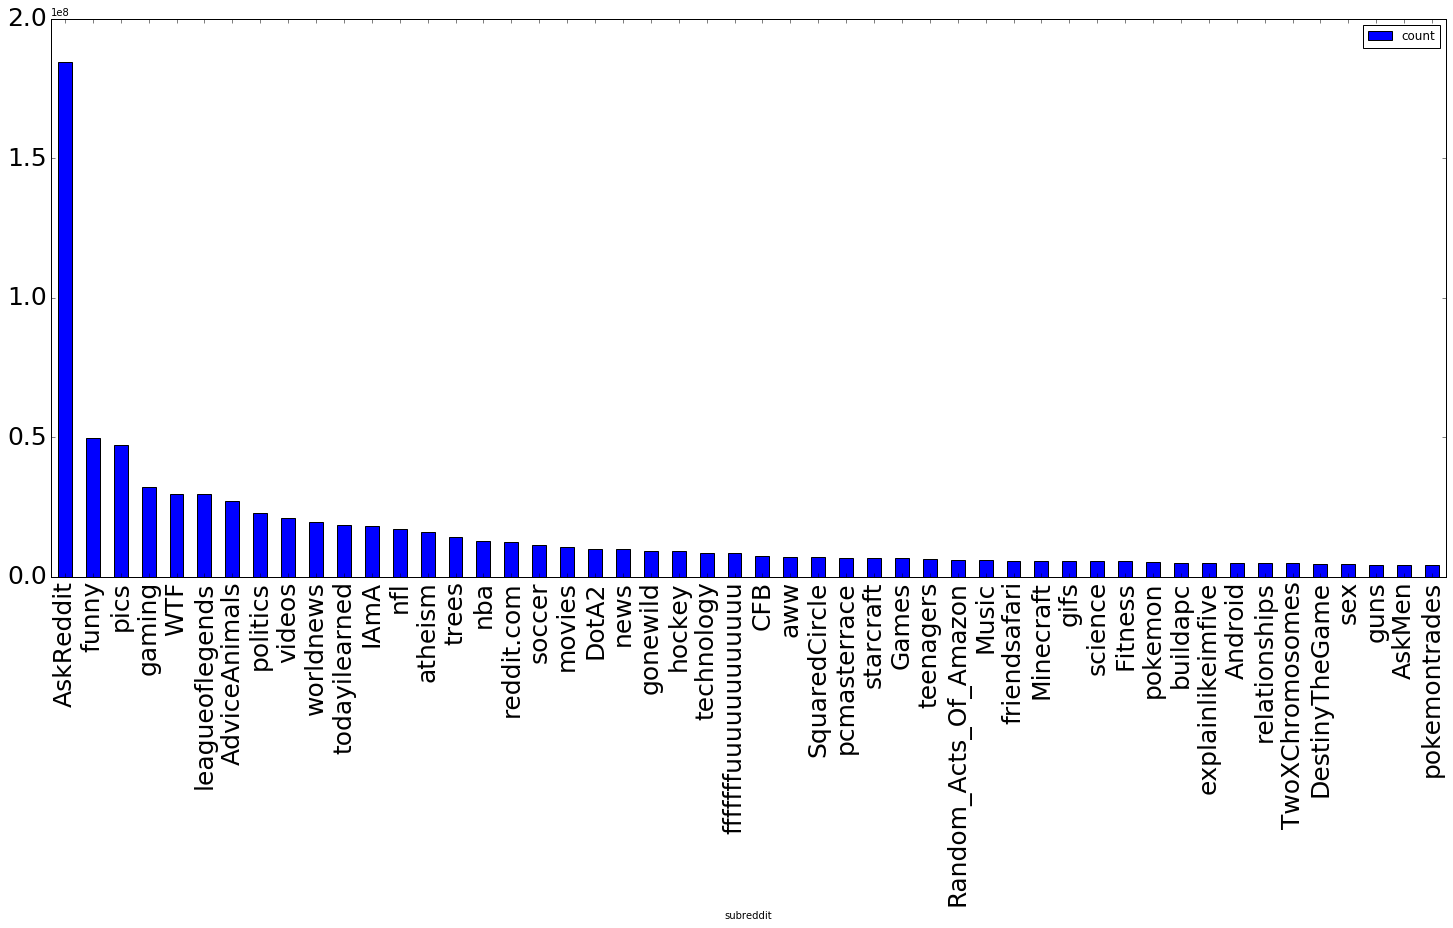

In [100]:
pandas_df.plot('subreddit', 'count', kind='bar', figsize=(25, 10), fontsize=25)

#### Now, let's determine the most active commenters.

But first, we should filter out the records with 'author' field of '[deleted]'.

In [101]:
%%time
nondel_authors = reddit.filter(reddit['author'] != '[deleted]').cache()

CPU times: user 3.45 ms, sys: 967 µs, total: 4.42 ms
Wall time: 22.9 ms


In [102]:
%%time
nondel_authors.count()

CPU times: user 37.1 ms, sys: 26.5 ms, total: 63.6 ms
Wall time: 3min 8s


1430935783

#### Since we have created another large data frame and assuming we are done with the reddit dataframe we can unpersist it, which will remove it from cache.

In [103]:
%%time
reddit.unpersist()

CPU times: user 1.23 ms, sys: 2.03 ms, total: 3.25 ms
Wall time: 54.6 ms


DataFrame[approved_by: string, archived: boolean, author: string, author_flair_css_class: string, author_flair_text: string, banned_by: string, body: string, body_html: string, controversiality: bigint, created: bigint, created_utc: string, distinguished: string, downs: bigint, edited: string, gilded: bigint, id: string, likes: string, link_id: string, mod_reports: array<string>, name: string, num_reports: string, parent_id: string, removal_reason: string, replies: string, report_reasons: string, retrieved_on: bigint, saved: boolean, score: bigint, score_hidden: boolean, subreddit: string, subreddit_id: string, ups: bigint, user_reports: array<string>]

#### Lets group records by author and count them. This also sorts the resulting data frame.

In [104]:
%%time
top_commenters = nondel_authors.groupBy("author").count().sort("count", ascending=False)

CPU times: user 3.53 ms, sys: 5.79 ms, total: 9.32 ms
Wall time: 27.7 ms


In [105]:
%%time
top_commenters.cache()

CPU times: user 4.91 ms, sys: 2.27 ms, total: 7.18 ms
Wall time: 20.8 s


DataFrame[author: string, count: bigint]

#### How many unique authors?

In [106]:
%%time
top_commenters.count()

CPU times: user 16.3 ms, sys: 6.12 ms, total: 22.4 ms
Wall time: 1min 51s


13213172

#### Another simple way to convert the Spark data frame to a .csv file.

In [110]:
%%time
top50commenters = top_commenters.take(50)

CPU times: user 11 ms, sys: 5.02 ms, total: 16 ms
Wall time: 91.4 ms


In [111]:
print(top50commenters)

[Row(author=u'AutoModerator', count=3677774), Row(author=u'conspirobot', count=575576), Row(author=u'ModerationLog', count=547671), Row(author=u'autowikibot', count=402076), Row(author=u'PoliticBot', count=388395), Row(author=u'imgurtranscriber', count=360248), Row(author=u'dogetipbot', count=358093), Row(author=u'qkme_transcriber', count=301968), Row(author=u'TweetPoster', count=293309), Row(author=u'Late_Night_Grumbler', count=279038), Row(author=u'morbiusgreen', count=185501), Row(author=u'-rix', count=173022), Row(author=u'pixis-4950', count=171907), Row(author=u'Franciscouzo', count=170767), Row(author=u'UnluckyLuke', count=162505), Row(author=u'Lots42', count=154518), Row(author=u'PornOverlord', count=136766), Row(author=u'MTGCardFetcher', count=125794), Row(author=u'hit_bot', count=125645), Row(author=u'matts2', count=123834), Row(author=u'havoc_bot', count=118570), Row(author=u'NoMoreNicksLeft', count=117697), Row(author=u'CaptionBot', count=116147), Row(author=u'iam4real', cou

In [116]:
with open('top50commenters.csv', 'w') as fp:
    fp.write('author,count\n')
    for row in top50commenters:
        fp.write(row['author'] + ',' + str(long(row['count'])) + '\n')

In [119]:
!cat top50commenters.csv

author,count
AutoModerator,3677774
conspirobot,575576
ModerationLog,547671
autowikibot,402076
PoliticBot,388395
imgurtranscriber,360248
dogetipbot,358093
qkme_transcriber,301968
TweetPoster,293309
Late_Night_Grumbler,279038
morbiusgreen,185501
-rix,173022
pixis-4950,171907
Franciscouzo,170767
UnluckyLuke,162505
Lots42,154518
PornOverlord,136766
MTGCardFetcher,125794
hit_bot,125645
matts2,123834
havoc_bot,118570
NoMoreNicksLeft,117697
CaptionBot,116147
iam4real,108503
G_Morgan,104996
andrewsmith1986,104578
SoulFire6464,100688
NinjaDiscoJesus,98249
backpackwayne,93836
eaturbrainz,92198
original-finder,91576
MasterT231,87611
smacksaw,85682
Frankeh,83907
atomicimploder,82885
Release_the_KRAKEN,82006
changetip,81536
Sir_Willis_CMS,80783
king_kalamari,80076
totes_meta_bot,79890
V2Blast,79877
ttumblrbots,78755
nikorasu_the_great,78422
PriceZombie,76070
JonAudette,75735
MultiFunctionBot,74408
savoytruffle,73439
AMerrickanGirl,73145
ravenluna,70851
MovieGuide,70754


#### These 'summary' csv files may be downloaded and loaded into other programs like Excel and Tableau. For further analysis and visualization.